In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
window_size_ms = 200.
samples_per_window = 20

n = number of windows

`all_data`: (n, samples_per_window, 6) data (acc_x,acc_y,acc_z, gyro_x, gyro_y, gyro_z)

`has_touch`: (n,) array of +/-1 (bool for whether touch occured in this window)

`touch_loc`: (n,2) array of (x,y) touch locations

All times are adjusted so the first time in the dataset is 0.

In [3]:
dataset = "dataPixelRHandStandingRandom"
with open(dataset + ".csv") as f:
    # touch_x, touch_y, sensor, t, x, y, z = row
    csvreader = csv.reader(f)
    csvf = list(csvreader)
print(csvf[0])
start_time = int(csvf[0][3])
print("Total time (s): ", (int(csvf[-1][3]) - start_time)/1000)

['-2.0', '-2.0', 'accelerometer', '1556846706990', '0.023820243775844574', '0.19748443365097046', '0.9562157988548279']
Total time (s):  216.941


In [4]:
def normalize(arr):
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    print("Mean: ", mean)
    print("Std: ", std)
    return (arr - mean) / std

In [5]:
# Separate acc and gyro data
acc_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "accelerometer"])

acc_data[:, 1:] = normalize(acc_data[:, 1:])

gyro_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "gyroscope"])

gyro_data[:, 1:] = normalize(gyro_data[:, 1:])

end_time = max(acc_data[-1][0], gyro_data[-1][0])
num_windows = math.ceil((end_time / window_size_ms))
num_samples = num_windows * samples_per_window
print("Total time: ", end_time)
print("Num windows:", num_windows)
print("Num samples: ", num_samples)

Mean:  [-0.06637303  0.2510089   0.97075055]
Std:  [0.12687783 0.096687   0.16449059]
Mean:  [ 0.00199213  0.00373721 -0.00024137]
Std:  [0.37695416 0.69870195 0.25791818]
Total time:  216941.0
Num windows: 1085
Num samples:  21700


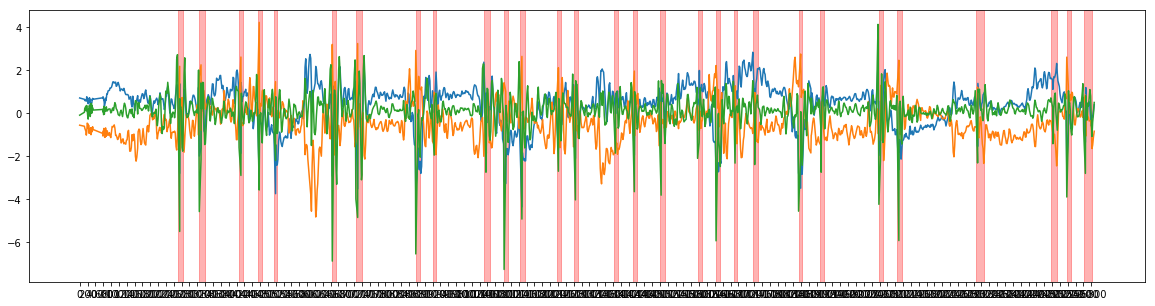

In [7]:
plt.figure(figsize=(20,5))

num_samples_to_view = 1500
end_time = acc_data[num_samples_to_view - 1][0]
acc_data_t_ms = acc_data[:num_samples_to_view, 0]
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 1])
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 2])
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 3])

presses = [int(x[3]) - start_time for x in csvf if x[2] == "press" if int(x[3]) - start_time < end_time]
releases = [int(x[3]) - start_time for x in csvf if x[2] == "release" if int(x[3]) - start_time < end_time]

presses = presses[:min(len(presses), len(releases))]

for i in range(len(presses)):
    plt.axvspan(presses[i], releases[i], alpha=0.3, color="r")
    
plt.xticks(np.arange(0, end_time, step=200))
plt.show()

In [8]:
# Interpolate
interp_times = np.linspace(0, end_time, num=num_samples)

acc_data_ts = acc_data[:,0]
# Check times all increasing
assert(np.all(np.diff(acc_data_ts) > 0))
acc_data_interp = [
    np.interp(interp_times, acc_data_ts, acc_data[:,1]),
    np.interp(interp_times, acc_data_ts, acc_data[:,2]),
    np.interp(interp_times, acc_data_ts, acc_data[:,3]),
]

gyro_data_ts = gyro_data[:,0]
assert(np.all(np.diff(gyro_data_ts) > 0))
gyro_data_interp = [
    np.interp(interp_times, gyro_data_ts, gyro_data[:,1]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,2]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,3]),
]

all_data = np.concatenate((acc_data_interp, gyro_data_interp), axis=0).T
assert(all_data.shape == (num_samples, 6))
all_data = np.array(np.split(all_data, num_windows))
assert(all_data.shape == (num_windows, samples_per_window, 6))
print("Done.")

Done.


In [34]:
# Collect touch labels
# has_touch = 1 if there is a touch ONSET in that window
# TODO: might want to test this assumption

# (# presses, 3) array of (window #, touch_x, touch_y)
press_locs = np.array([[
    int(math.floor((int(x[3]) - start_time) / window_size_ms)), float(x[0]), float(x[1])
] for x in csvf if x[2] == "press"])

has_touch = -1 * np.ones((num_windows,))
touch_loc = -2 * np.ones((num_windows, 2))

has_touch[press_locs[:,0].astype(int)] = 1
touch_loc[press_locs[:,0].astype(int)] = press_locs[:,1:]
touch_loc = normalize(touch_loc)

assert(has_touch.shape == (num_windows,))
print("Number touch windows", np.sum(has_touch == 1))
print("Number no touch windows", np.sum(has_touch == -1))
assert(touch_loc.shape == (num_windows, 2))

Mean:  [ 80.6125081  165.01724772]
Std:  [113.66803279 213.79797616]
Number touch windows 427
Number no touch windows 658


[ 0.71086707 -0.55358493 -0.08836221  0.01560245  0.14975013  0.22350085
  0.71025974 -0.5540796  -0.08702239  0.01560245  0.14975013  0.22350085
  0.70965242 -0.55457427 -0.08568257  0.01560245  0.14975013  0.22350085
  0.70904509 -0.55506895]
[-0.08434274  0.01560245  0.14975013  0.22350085  0.70843777 -0.55556362
 -0.08300292  0.01468491  0.14922148  0.22306376  0.70783044 -0.5560583
 -0.0816631   0.0132639   0.14840275  0.22238684  0.70722311 -0.55655297
 -0.08032327  0.01184289]


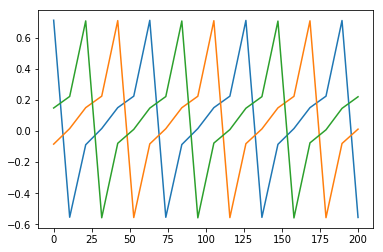

In [39]:
# Visualize touch / no touch windows
all_data = all_data.reshape(-1, samples_per_window * 6)

print(all_data[i,:samples_per_window])
print(all_data[i,samples_per_window:2*samples_per_window])
for i in range(len(has_touch)):
    if has_touch[i]:
        plt.plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:samples_per_window])
        plt.plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,samples_per_window:2*samples_per_window])
        plt.plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,2*samples_per_window:3*samples_per_window])

        plt.show()
        break

In [22]:
# Flatten into one feature vector before saving
all_data = all_data.reshape(-1, samples_per_window * 6)

print("all_data: ", all_data.shape)
print("has_touch: ", has_touch.shape)
print("touch_loc: ", touch_loc.shape)
np.save("processed/{}_x.npy".format(dataset), all_data)
np.save("processed/{}_has_touch_y.npy".format(dataset), has_touch)
np.save("processed/{}_touch_loc_y.npy".format(dataset), touch_loc)

all_data:  (1085, 120)
has_touch:  (1085,)
touch_loc:  (1085, 2)


# ~ machine learning ~

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [28]:
model = Sequential()
model.add(Dense(64, activation="relu", input_dim=(samples_per_window * 6)))
model.add(Dense(1, activation="tanh"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                7744      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 7,809
Trainable params: 7,809
Non-trainable params: 0
_________________________________________________________________


In [29]:
skf = StratifiedKFold(n_splits = 5)

In [30]:
accs = []
for train_idx, test_idx in skf.split(all_data, has_touch):
    x_train, x_test = all_data[train_idx], all_data[test_idx]
    y_train, y_test = has_touch[train_idx], has_touch[test_idx]
    
    model.fit(x_train, y_train, epochs=100)
    _, acc = model.evaluate(x_test, y_test)
    print("ACCURACY: ", acc)
    accs.append(acc)

Epoch 1/100
867/867 [==============================] - 0s - loss: -2.6879 - acc: 0.2399     
Epoch 2/100
867/867 [==============================] - 0s - loss: -2.8794 - acc: 0.4118     
Epoch 3/100
867/867 [==============================] - 0s - loss: -3.0896 - acc: 0.4706    
Epoch 4/100
867/867 [==============================] - 0s - loss: -3.2906 - acc: 0.4856     
Epoch 5/100
867/867 [==============================] - 0s - loss: -3.0225 - acc: 0.4867     
Epoch 6/100
867/867 [==============================] - 0s - loss: -2.9494 - acc: 0.4925     
Epoch 7/100
867/867 [==============================] - 0s - loss: -3.1090 - acc: 0.4971    
Epoch 8/100
867/867 [==============================] - 0s - loss: -3.2043 - acc: 0.5063     
Epoch 9/100
867/867 [==============================] - 0s - loss: -3.3657 - acc: 0.5144     
Epoch 10/100
867/867 [==============================] - 0s - loss: -2.5865 - acc: 0.4694     
Epoch 11/100
867/867 [==============================] - 0s - loss: -2.8

867/867 [==============================] - 0s - loss: -3.4759 - acc: 0.6032     
Epoch 89/100
867/867 [==============================] - 0s - loss: -3.4760 - acc: 0.6032     
Epoch 90/100
867/867 [==============================] - 0s - loss: -3.4760 - acc: 0.6021     
Epoch 91/100
867/867 [==============================] - 0s - loss: -3.4760 - acc: 0.6021     
Epoch 92/100
867/867 [==============================] - 0s - loss: -3.4760 - acc: 0.6021     
Epoch 93/100
867/867 [==============================] - 0s - loss: -3.4760 - acc: 0.6021     
Epoch 94/100
867/867 [==============================] - 0s - loss: -3.4761 - acc: 0.6009      
Epoch 95/100
867/867 [==============================] - 0s - loss: -3.4761 - acc: 0.6009     
Epoch 96/100
867/867 [==============================] - 0s - loss: -3.4761 - acc: 0.6009     
Epoch 97/100
867/867 [==============================] - 0s - loss: -3.4796 - acc: 0.6044     
Epoch 98/100
867/867 [==============================] - 0s - loss: -3.45

867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 75/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 76/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 77/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 78/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 79/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 80/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 81/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 82/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 83/100
867/867 [==============================] - 0s - loss: -3.4393 - acc: 0.5986     
Epoch 84/100
867/867 [==============================] - 0s - loss: -3.439

868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 61/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 62/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 63/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 64/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 65/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 66/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 67/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 68/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 69/100
868/868 [==============================] - 0s - loss: -3.4167 - acc: 0.6060     
Epoch 70/100
868/868 [==============================] - 0s - loss: -3.416

869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064        
Epoch 47/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 48/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064    
Epoch 49/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 50/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 51/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 52/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 53/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 54/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 55/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 56/100
869/869 [==============================] - 0s - loss: -3.4

869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 33/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 34/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 35/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 36/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064    
Epoch 37/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064    
Epoch 38/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 39/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 40/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064        
Epoch 41/100
869/869 [==============================] - 0s - loss: -3.4314 - acc: 0.6064     
Epoch 42/100
869/869 [==============================] - 0s - loss: -3.43

In [31]:
np.mean(accs)

0.6000313948399534